## Предсказание стомости квартиры

Целевая переменная: Price

Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

### Подготовка

#### Подключаем библиотеки и скрипты

In [160]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from datetime import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

#### Устанавливаем одинаковый размер шрифта

In [151]:
matplotlib.rcParams.update({'font.size': 12})

#### Задаем функцию для подсчета метрик

In [170]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(12,6))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

#### Пути к директориям и файлам

In [7]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

### Работа с файлами

#### Описание датасета

#### Читаем тренировочный набор данных

In [9]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=',')
train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
5,5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B,161044.944138
6,8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,B,B,24,4860,1,80.0,0,3,B,142402.739272
7,13072,59,2.0,50.391814,32.893256,8.0,8,17.0,1986,0.019509,B,B,37,7687,11,176.0,5,5,B,326174.175191
8,9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.401732
9,8094,6,3.0,79.867477,75.085125,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,194756.023945


In [10]:
train_df.shape

(10000, 20)

In [11]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

#### Читаем тестовый набор данных

In [12]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


#### Сравниваем наборы данных

In [45]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте:', test_df.shape[0])

Строк в трейне: 10000
Строк в тесте: 5000


In [46]:
train_df.shape[1] - 1 == test_df.shape[1]

True

### Анализ данных

#### Целевая переменная

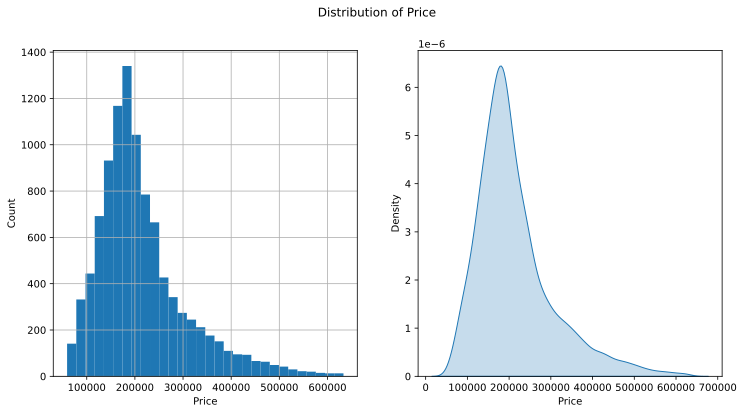

In [164]:
plt.figure(figsize = (12, 6))

plt.subplot(121)
train_df['Price'].hist(density=False, bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(train_df['Price'], shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of Price')
plt.show()

In [53]:
target_mean = round(train_df['Price'].mean(), 2)
target_median = train_df['Price'].median()
target_mode = train_df['Price'].mode()[0]

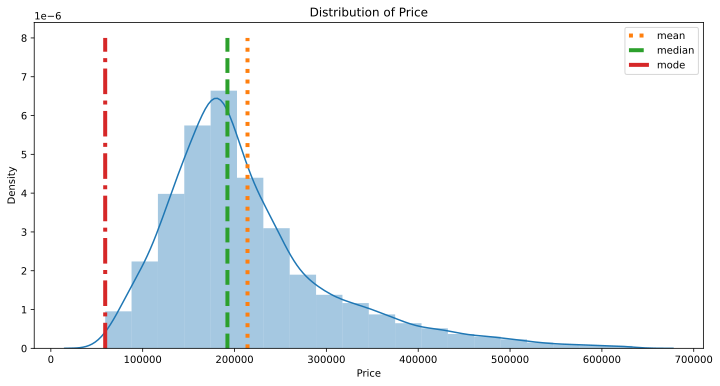

In [165]:
plt.figure(figsize = (12, 6))

sns.distplot(train_df['Price'], bins=20)

y = np.linspace(0, 0.000008, 10)
plt.plot([target_mean] * 10, y, label='mean', linestyle=':', linewidth=4)
plt.plot([target_median] * 10, y, label='median', linestyle='--', linewidth=4)
plt.plot([target_mode] * 10, y, label='mode', linestyle='-.', linewidth=4)

plt.title('Distribution of Price')
plt.legend()
plt.show()

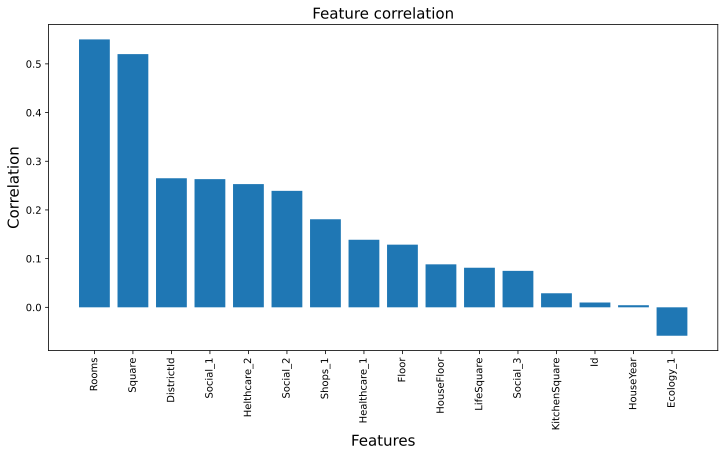

In [166]:
correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (12, 6))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

#### Приведение типов

In [60]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['Id'].dtype

dtype('O')

In [61]:
train_df['DistrictId'] = train_df['DistrictId'].astype(str)
train_df['DistrictId'].dtype

dtype('O')

In [62]:
binary_to_numbers = {'A': 0, 'B': 1}

train_df['Ecology_2'] = train_df['Ecology_2'].replace(binary_to_numbers)
train_df['Ecology_3'] = train_df['Ecology_3'].replace(binary_to_numbers)
train_df['Shops_2'] = train_df['Shops_2'].replace(binary_to_numbers)

#### Количественные переменные

In [63]:
train_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,0.990300,0.972500,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,0.917500,214138.857399
std,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,0.098015,0.163543,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,0.275139,92872.293865
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,1.000000,1.000000,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,1.000000,153872.633942
50%,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,1.000000,1.000000,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,1.000000,192269.644879
75%,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,1.000000,1.000000,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,1.000000,249135.462171
max,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,1.000000,1.000000,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,1.000000,633233.466570


#### Категориальные признаки

In [64]:
train_df.select_dtypes(include='object').columns.tolist()

['Id', 'DistrictId']

In [65]:
train_df['DistrictId'].value_counts()

27     851
1      652
23     565
6      511
9      294
      ... 
199      1
117      1
207      1
209      1
174      1
Name: DistrictId, Length: 205, dtype: int64

#### Обработка выбросов

#### Rooms

In [68]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [69]:
train_df['Rooms_outlier'] = 0
train_df.loc[(train_df['Rooms'] == 0) | (train_df['Rooms'] >= 6), 'Rooms_outlier'] = 1
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,...,1,11,3097,0,NaN,0,0,1,305018.871089,0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,30,6207,1,1183.0,1,0,1,177734.553407,0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,33,5261,0,240.0,3,1,1,282078.720850,0
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,...,1,1,264,0,NaN,0,1,1,168106.007630,0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,1,33,8667,2,NaN,0,6,1,343995.102962,0


In [70]:
train_df.loc[train_df['Rooms'] == 0, 'Rooms'] = 1
train_df.loc[train_df['Rooms'] >= 6, 'Rooms'] = train_df['Rooms'].median()

In [71]:
train_df['Rooms'].value_counts()

2.0    3884
1.0    3713
3.0    2235
4.0     150
5.0      18
Name: Rooms, dtype: int64

#### Square

In [72]:
train_df['Square'].sort_values().unique()

array([  1.13685878,   1.98894272,   2.37724759, ..., 409.42518143,
       604.70597195, 641.06519275])

In [73]:
train_df['Square'].quantile(.975), train_df['Square'].quantile(.025)

(100.90624548226137, 32.10518291149681)

In [74]:
condition_sq = (train_df['Square'].isna()) \
             | (train_df['Square'] < train_df['Square'].quantile(.025))
        
train_df.loc[condition_sq, 'Square'] = train_df['Square'].quantile(.025)

In [75]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027311,NaN,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,NaN,1.0
4,64.285067,38.562517,9.0
5,62.528465,47.103833,6.0
6,33.938750,21.772930,9.0
7,50.391814,32.893256,8.0
8,46.887892,44.628132,1.0
9,79.867477,75.085125,1.0


#### KitchenSquare

In [76]:
train_df['KitchenSquare'].value_counts()

1.0       2460
8.0       1306
5.0       1169
10.0      1075
6.0       1038
9.0        843
0.0        697
7.0        609
12.0       249
11.0       233
13.0        67
14.0        51
4.0         39
15.0        31
3.0         22
16.0        16
20.0        14
17.0        12
19.0        11
18.0         6
2.0          4
22.0         3
30.0         2
43.0         2
41.0         2
112.0        2
25.0         2
51.0         2
37.0         2
58.0         2
32.0         2
21.0         1
73.0         1
75.0         1
36.0         1
27.0         1
63.0         1
1970.0       1
54.0         1
53.0         1
60.0         1
26.0         1
66.0         1
39.0         1
29.0         1
78.0         1
31.0         1
84.0         1
48.0         1
96.0         1
42.0         1
40.0         1
23.0         1
72.0         1
35.0         1
62.0         1
123.0        1
2014.0       1
Name: KitchenSquare, dtype: int64

In [77]:
train_df['KitchenSquare'].quantile(.975), train_df['KitchenSquare'].quantile(.025)

(13.0, 0.0)

In [78]:
condition_k = (train_df['KitchenSquare'].isna()) \
             | (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.975))
        
train_df.loc[condition_k, 'KitchenSquare'] = train_df['KitchenSquare'].median()

train_df.loc[train_df['KitchenSquare'] < 5, 'KitchenSquare'] = 5

In [79]:
train_df['KitchenSquare'].value_counts()

5.0     4391
8.0     1306
6.0     1227
10.0    1075
9.0      843
7.0      609
12.0     249
11.0     233
13.0      67
Name: KitchenSquare, dtype: int64

In [80]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027311,NaN,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,NaN,5.0
4,64.285067,38.562517,9.0
5,62.528465,47.103833,6.0
6,33.938750,21.772930,9.0
7,50.391814,32.893256,8.0
8,46.887892,44.628132,5.0
9,79.867477,75.085125,5.0


#### LifeSquare

In [81]:
train_df['LifeSquare'].sort_values().unique()

array([3.70619419e-01, 6.41822108e-01, 7.95539468e-01, ...,
       6.38163193e+02, 7.48059213e+03,            nan])

In [82]:
train_df['LifeSquare_nan'] = train_df['LifeSquare'].isna() * 1

condition_l = (train_df['LifeSquare'].isna()) \
             & (~train_df['Square'].isna()) \
             & (~train_df['KitchenSquare'].isna())
        
train_df.loc[condition_l, 'LifeSquare'] = train_df.loc[condition_l, 'Square'] \
                                            - train_df.loc[condition_l, 'KitchenSquare'] - 3

In [83]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027311,102.027311,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,32.409907,5.0
4,64.285067,38.562517,9.0
5,62.528465,47.103833,6.0
6,33.938750,21.772930,9.0
7,50.391814,32.893256,8.0
8,46.887892,44.628132,5.0
9,79.867477,75.085125,5.0


In [84]:
train_df['LifeSquare'].sort_values().unique()

array([3.70619419e-01, 6.41822108e-01, 7.95539468e-01, ...,
       5.96705972e+02, 6.38163193e+02, 7.48059213e+03])

In [85]:
train_df['LifeSquare'].quantile(.975), train_df['LifeSquare'].quantile(.025)

(83.79619739064069, 15.146123972262354)

In [87]:
condition_ls = (train_df['LifeSquare'].isna()) \
             | (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.025))
        
train_df.loc[condition_ls, 'LifeSquare'] = train_df['LifeSquare'].quantile(.025)
train_df.loc[train_df['LifeSquare'] > 639, 'LifeSquare'] = 638

In [88]:
train_df['LifeSquare'].sort_values().unique()

array([ 15.14612397,  15.14628994,  15.16864386, ..., 596.70597195,
       638.        , 638.16319344])

In [89]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027311,102.027311,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,32.409907,5.0
4,64.285067,38.562517,9.0
5,62.528465,47.103833,6.0
6,33.938750,21.772930,9.0
7,50.391814,32.893256,8.0
8,46.887892,44.628132,5.0
9,79.867477,75.085125,5.0


In [91]:
(train_df['Square'] < (train_df['LifeSquare'] + train_df['KitchenSquare'])).sum()

1173

In [92]:
wrong_square = train_df.loc[train_df['Square'] < (train_df['LifeSquare'] \
                                                  + train_df['KitchenSquare'])].index
wrong_square

Int64Index([   8,    9,   19,   33,   34,   37,   42,   48,   64,   77,
            ...
            9939, 9942, 9947, 9954, 9960, 9962, 9965, 9979, 9987, 9993],
           dtype='int64', length=1173)

In [93]:
train_df[['Square', 'LifeSquare', 'KitchenSquare']].head(10)

,Square,LifeSquare,KitchenSquare
0,115.027311,102.027311,10.0
1,39.832524,23.169223,8.0
2,78.342215,47.671972,10.0
3,40.409907,32.409907,5.0
4,64.285067,38.562517,9.0
5,62.528465,47.103833,6.0
6,33.938750,21.772930,9.0
7,50.391814,32.893256,8.0
8,46.887892,44.628132,5.0
9,79.867477,75.085125,5.0


In [94]:
train_df.loc[wrong_square, 'Square'] = train_df.loc[wrong_square, 'LifeSquare'] \
                                            + train_df.loc[wrong_square, 'KitchenSquare'] + 3

In [95]:
(train_df['Square'] < (train_df['LifeSquare'] + train_df['KitchenSquare'])).sum()

0

#### HouseFloor, Floor

In [96]:
train_df['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.])

In [97]:
train_df['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int64)

In [98]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

1825

In [99]:
train_df['HouseFloor_outlier'] = 0
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'HouseFloor_outlier'] = 1

In [100]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [101]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
floor_outliers

Int64Index([  17,   19,   21,   25,   26,   33,   34,   37,   39,   44,
            ...
            9913, 9921, 9930, 9931, 9938, 9953, 9960, 9968, 9970, 9975],
           dtype='int64', length=1610)

In [102]:
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor']\
                                                .apply(lambda x: random.randint(1, x))

In [104]:
(train_df['Floor'] > train_df['HouseFloor']).sum()

0

#### HouseYear

In [105]:
train_df['HouseYear'].sort_values(ascending=False)

9163    20052011
8828        4968
7721        2020
9122        2020
7955        2020
          ...   
7610        1916
6250        1914
2066        1912
2795        1912
6794        1910
Name: HouseYear, Length: 10000, dtype: int64

In [106]:
train_df.loc[train_df['HouseYear'] > 2020, 'HouseYear'] = 2020

#### Проверим оставшиеся пропуски

In [107]:
train_df.isna().sum()

Id                       0
DistrictId               0
Rooms                    0
Square                   0
LifeSquare               0
KitchenSquare            0
Floor                    0
HouseFloor               0
HouseYear                0
Ecology_1                0
Ecology_2                0
Ecology_3                0
Social_1                 0
Social_2                 0
Social_3                 0
Healthcare_1          4798
Helthcare_2              0
Shops_1                  0
Shops_2                  0
Price                    0
Rooms_outlier            0
LifeSquare_nan           0
HouseFloor_outlier       0
dtype: int64

In [108]:
train_df.drop('Healthcare_1', axis=1, inplace=True)

### Создание класса подготовки данных

In [109]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.square_quantile = None
        self.life_square_quantile = None
        self.kitchen_square_quantile = None
        self.binary_to_numbers = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.square_quantile = X['Square'].quantile(.025)
        self.life_square_quantile = X['LifeSquare'].quantile(.025)
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
    
    def transform(self, X):
        """Трансформация данных"""
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)

        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # Square
        condition_sq = (X['Square'].isna()) \
                     | (X['Square'] < X['Square'].quantile(.025))
        
        X.loc[condition_sq, 'Square'] = X['Square'].quantile(.025)
        
        # KitchenSquare
        condition_k = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > X['KitchenSquare'].quantile(.975))
        
        X.loc[condition_k, 'KitchenSquare'] = X['KitchenSquare'].median()

        X.loc[X['KitchenSquare'] < 5, 'KitchenSquare'] = 5
        
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1

        condition_l = (X['LifeSquare'].isna()) \
                    & (~X['Square'].isna()) \
                    & (~X['KitchenSquare'].isna())
        
        X.loc[condition_l, 'LifeSquare'] = X.loc[condition_l, 'Square'] \
                                            - X.loc[condition_l, 'KitchenSquare'] - 3
        ###
        condition_ls = (X['LifeSquare'].isna()) \
                     | (X['LifeSquare'] < X['LifeSquare'].quantile(.025))
        
        X.loc[condition_ls, 'LifeSquare'] = X['LifeSquare'].quantile(.025)
        X.loc[X['LifeSquare'] > 639, 'LifeSquare'] = 638
        
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        
        floor_outliers = X.loc[X['Floor'] > X['HouseFloor']].index
        X.loc[floor_outliers, 'Floor'] = X.loc[floor_outliers, 'HouseFloor']\
                                            .apply(lambda x: random.randint(1, x))
        
        # HouseYear
        current_year = datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        X.fillna(self.medians, inplace=True)
        
        return X

### Построение новых признаков

#### DistrictSize, IsDistrictLarge

In [110]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})

district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [111]:
train_df = train_df.merge(district_size, on='DistrictId', how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,LifeSquare_nan,HouseFloor_outlier,DistrictSize
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,3097,0,0,0,1,305018.871089,0,1,0,851
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,6207,1,1,0,1,177734.553407,0,0,0,78
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,5261,0,3,1,1,282078.720850,0,0,0,652
3,2352,1,1.0,40.409907,32.409907,5.0,10,22.0,1977,0.007122,...,264,0,0,1,1,168106.007630,0,1,0,652
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,8667,2,0,6,1,343995.102962,0,0,0,89


In [112]:
(train_df['DistrictSize'] > 100).value_counts()

True     5069
False    4931
Name: DistrictSize, dtype: int64

In [113]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

#### MedPriceByDistrict - средняя цена квартиры по району

In [114]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                            .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [115]:
med_price_by_district.shape

(667, 3)

In [116]:
train_df = train_df.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Rooms_outlier,LifeSquare_nan,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,0,1,305018.871089,0,1,0,851,1,213530.788443
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,1,0,1,177734.553407,0,0,0,78,0,146032.829834
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,3,1,1,282078.720850,0,0,0,652,1,244005.272380
3,2352,1,1.0,40.409907,32.409907,5.0,10,22.0,1977,0.007122,...,0,1,1,168106.007630,0,1,0,652,1,146735.671740
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,6,1,343995.102962,0,0,0,89,0,201584.441255
5,5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,...,2,4,1,161044.944138,0,0,0,97,0,223960.229617
6,8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,...,0,3,1,142402.739272,0,0,0,104,1,171145.169069
7,13072,59,2.0,50.391814,32.893256,8.0,8,17.0,1986,0.019509,...,5,5,1,326174.175191,0,0,0,67,0,326174.175191
8,9951,1,1.0,52.628132,44.628132,5.0,12,20.0,1977,0.007122,...,0,1,1,160400.401732,0,0,0,652,1,146735.671740
9,8094,6,3.0,83.085125,75.085125,5.0,3,17.0,2014,0.243205,...,0,0,1,194756.023945,0,0,0,511,1,215707.925347


#### MedSqPriceByDistrict - средняя цена кв.метра по району

In [117]:
med_sq_price_by_district = train_df.groupby(['DistrictId'])\
.agg({'Square': 'sum', 'Price': 'sum'}).rename(columns={'Price':'MedSqPriceByDistrict'})

med_sq_price_by_district.loc[:, 'MedSqPriceByDistrict']\
= med_sq_price_by_district['MedSqPriceByDistrict']\
                              / med_sq_price_by_district['Square']
med_sq_price_by_district.drop('Square', axis=1, inplace=True)
train_df = train_df.merge(med_sq_price_by_district, on='DistrictId', how='left')
train_df

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Shops_1,Shops_2,Price,Rooms_outlier,LifeSquare_nan,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict,MedSqPriceByDistrict
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,1,305018.871089,0,1,0,851,1,213530.788443,2567.712368
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,1,177734.553407,0,0,0,78,0,146032.829834,3634.144243
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,1,1,282078.720850,0,0,0,652,1,244005.272380,3064.266882
3,2352,1,1.0,40.409907,32.409907,5.0,10,22.0,1977,0.007122,...,1,1,168106.007630,0,1,0,652,1,146735.671740,3064.266882
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,6,1,343995.102962,0,0,0,89,0,201584.441255,4150.798823
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,...,9,1,119367.455796,0,0,0,118,1,232514.855623,4291.717138
9996,16265,27,2.0,64.307684,37.038420,9.0,13,13.0,1977,0.072158,...,0,0,199715.148807,0,0,1,851,1,165683.084779,2567.712368
9997,2795,178,1.0,32.105183,16.555363,5.0,3,5.0,1958,0.460556,...,5,1,165953.912580,0,0,0,7,0,165953.912580,5066.786562
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,...,5,1,171842.411855,0,0,0,165,1,153921.400690,4040.570217


#### MedPriceByFloorYear

In [118]:
def floor_to_cat(X):

    bins = [X['Floor'].min(), 3, 5, 9, 15, X['Floor'].max()]
    X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)
    
    X['floor_cat'].fillna(-1, inplace=True)
    return X


def year_to_cat(X):

    bins = [X['HouseYear'].min(), 1941, 1945, 1980, 2000, 2010, X['HouseYear'].max()]
    X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)
    
    X['year_cat'].fillna(-1, inplace=True)
    return X

In [119]:
train_df = year_to_cat(train_df)
train_df = floor_to_cat(train_df)
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Price,Rooms_outlier,LifeSquare_nan,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict,MedSqPriceByDistrict,year_cat,floor_cat
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,305018.871089,0,1,0,851,1,213530.788443,2567.712368,5.0,1.0
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,177734.553407,0,0,0,78,0,146032.829834,3634.144243,2.0,2.0
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,282078.720850,0,0,0,652,1,244005.272380,3064.266882,3.0,0.0
3,2352,1,1.0,40.409907,32.409907,5.0,10,22.0,1977,0.007122,...,168106.007630,0,1,0,652,1,146735.671740,3064.266882,2.0,3.0
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,343995.102962,0,0,0,89,0,201584.441255,4150.798823,2.0,4.0


In [120]:
med_price_by_floor_year = train_df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
med_price_by_floor_year.head(20)

,year_cat,floor_cat,MedPriceByFloorYear
0,-1.0,2.0,287954.720682
1,0.0,-1.0,321907.210867
2,0.0,0.0,402075.431031
3,0.0,1.0,324303.812481
4,0.0,2.0,421756.290145
5,0.0,3.0,274992.472366
6,1.0,0.0,467230.539057
7,1.0,1.0,509182.957515
8,2.0,-1.0,176682.487067
9,2.0,0.0,180322.969962


In [121]:
train_df = train_df.merge(med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Rooms_outlier,LifeSquare_nan,HouseFloor_outlier,DistrictSize,IsDistrictLarge,MedPriceByDistrict,MedSqPriceByDistrict,year_cat,floor_cat,MedPriceByFloorYear
0,11809,27,3.0,115.027311,102.027311,10.0,4,10.0,2014,0.075424,...,0,1,0,851,1,213530.788443,2567.712368,5.0,1.0,163969.984699
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,...,0,0,0,78,0,146032.829834,3634.144243,2.0,2.0,192913.798725
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,...,0,0,0,652,1,244005.272380,3064.266882,3.0,0.0,201995.028013
3,2352,1,1.0,40.409907,32.409907,5.0,10,22.0,1977,0.007122,...,0,1,0,652,1,146735.671740,3064.266882,2.0,3.0,183554.980077
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,...,0,0,0,89,0,201584.441255,4150.798823,2.0,4.0,173934.865013


### Генерация и отбор новых фич

In [133]:
class FeatureGenerator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.med_price_by_district = None
        self.med_sq_price_by_district = None
        self.med_sq_price_by_district_median = None
        self.med_price_by_floor_year = None
        self.med_price_by_floor_year_median = None
        self.house_year_max = None
        self.floor_max = None
        self.house_year_min = None
        self.floor_min = None
        self.district_size = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index()\
                    .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        ## District, Rooms
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            self.med_sq_price_by_district = df.groupby(['DistrictId'])\
            .agg({'Square': 'sum', 'Price': 'sum'}).rename(columns={'Price':'MedSqPriceByDistrict'})
            
            self.med_sq_price_by_district.loc[:, 'MedSqPriceByDistrict']\
            = self.med_sq_price_by_district['MedSqPriceByDistrict']\
                              / self.med_sq_price_by_district['Square']
            
            self.med_sq_price_by_district.drop('Square', axis=1, inplace=True)           
            self.med_sq_price_by_district_median = self.med_sq_price_by_district['MedSqPriceByDistrict'].median()
            
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            self.med_price_by_floor_year_median = self.med_price_by_floor_year['MedPriceByFloorYear'].median()
        

        
    def transform(self, X):
        
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['DistrictSize_nan'] = X['DistrictSize'].isna() * 1
        X['DistrictSize'].fillna(5, inplace=True)
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(np.int16)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + признак floor_cat
        X = self.year_to_cat(X)   # + признак year_cat
        
        if self.med_sq_price_by_district is not None:
            X = X.merge(self.med_sq_price_by_district, on='DistrictId', how='left')
            X.loc[X['MedSqPriceByDistrict'].isna(), 'MedSqPriceByDistrict'] = self.med_sq_price_by_district_median
            
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
            X.loc[X['MedPriceByFloorYear'].isna(), 'MedPriceByFloorYear'] = self.med_price_by_floor_year_median
        
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X

In [134]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [135]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2']

new_feature_names = ['Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan', 'DistrictSize',
                     'IsDistrictLarge', 'MedPriceByFloorYear', 'MedSqPriceByDistrict']

target_name = 'Price'

### Разделение на train и test

In [136]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [137]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [138]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape
((6700, 22), (3300, 22), (5000, 22))

((6700, 22), (3300, 22), (5000, 22))

In [139]:
features_gen = FeatureGenerator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 29), (3300, 29), (5000, 29))

In [140]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [141]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

### Построение модели

#### Обучение

In [142]:
rf_model = RandomForestRegressor(random_state=39, criterion='mse')
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=39)

#### Оценка модели

Train R2:	0.965
Test R2:	0.735


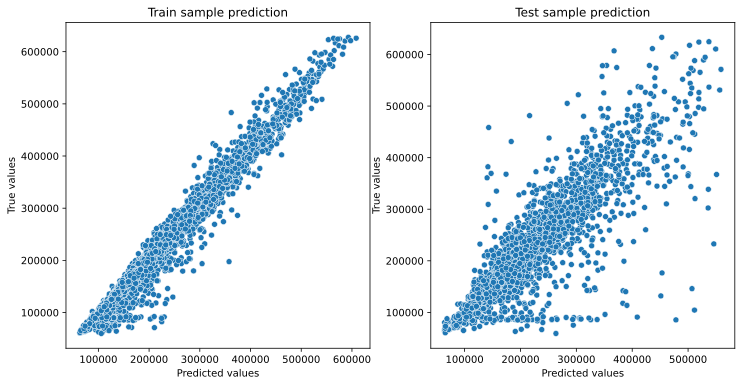

In [171]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

In [172]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.76102177, 0.7146367 , 0.75668875])

In [173]:
cv_score.mean()

0.7441157408416547

### Важность признаков

In [174]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.420066
23,MedSqPriceByDistrict,0.338734
2,LifeSquare,0.030314
22,MedPriceByFloorYear,0.024962
0,Rooms,0.023583
6,HouseYear,0.022538
11,Social_2,0.019140
5,HouseFloor,0.017738
4,Floor,0.016536
12,Social_3,0.014740


### Прогнозирование на тестовом датасете

In [175]:
test_df.shape

(5000, 24)

In [176]:
test_df

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,...,Shops_1,Shops_2,Rooms_outlier,HouseFloor_outlier,HouseYear_outlier,LifeSquare_nan,DistrictSize,IsDistrictLarge,MedPriceByFloorYear,MedSqPriceByDistrict
0,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,1,1,...,1,1,0,0,0,0,76.0,0,188251.441866,4541.571554
1,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,1,1,...,0,0,0,0,0,0,164.0,1,180042.914720,2743.077021
2,2.0,59.463678,47.463678,9.0,19,19.0,1977,0.211401,1,1,...,1,1,0,0,0,1,580.0,1,174339.691014,2705.238798
3,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,1,1,...,0,1,0,0,0,0,372.0,1,180857.345399,2236.964950
4,1.0,53.837056,45.837056,5.0,8,17.0,1977,0.309479,1,1,...,6,1,0,0,0,1,65.0,0,192086.822606,3356.176150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2.0,43.177521,30.339945,5.0,1,5.0,1962,0.069660,1,1,...,2,1,0,1,0,0,56.0,0,180857.345399,3932.710879
4996,3.0,93.698122,94.521465,10.0,21,27.0,2018,0.060753,1,1,...,7,1,0,0,0,0,26.0,0,193054.222191,4787.456514
4997,1.0,33.656723,19.003259,5.0,2,5.0,1966,0.038693,1,1,...,5,1,0,0,0,0,54.0,0,180857.345399,4031.163870
4998,1.0,38.635155,20.976257,9.0,8,14.0,1970,0.089040,1,1,...,11,1,0,0,0,0,40.0,0,192086.822606,4427.227136


In [177]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [179]:
predictions = rf_model.predict(test_df)
predictions

array([157590.35655506, 119217.78037026, 138512.47528598, ...,
       149018.94102479, 189181.43504213, 307230.23724743])

In [180]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,157590.356555
1,5925,119217.780370
2,960,138512.475286
3,3848,131392.327345
4,746,175209.670423


In [181]:
submit.to_csv('KKuznetsova_predictions.csv', index=False)